In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import pickle

from tensorflow import keras
from keras import models, layers
from keras.models import load_model

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from qiskit.visualization import plot_histogram 
import seaborn as sns
from collections import defaultdict


from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler


In [2]:
def NN_model(n_qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'relu', d = 0.0):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal, input_shape = (2 ** n_qubit, )))

    for i in range(n_hidden_layer):
        model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal))
        #model.add(layers.Dropout(d))
            
    model.add(layers.Dense(2 ** n_qubit, activation = 'softmax'))
    
    return model

def loss_function(p_ideal, p_mitigated, n_qubit):
    MSE = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
             x += (abs(p_mitigated[i][j] - p_ideal[i][j]) ** 2)
        x /= 2**n_qubit
        MSE += x
    MSE /= len(p_mitigated)

    KLD = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            if p_ideal[i][j] < 1e-15 or p_mitigated[i][j] < 1e-15:
                x += 0
            else:
                x += p_ideal[i][j] * (math.log(p_ideal[i][j]) - math.log(p_mitigated[i][j]))
        KLD += x
    KLD /= len(p_mitigated)
    
    IF = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            x += math.sqrt(p_ideal[i][j] * p_mitigated[i][j])
        IF += (1 - x**2)
    IF /= len(p_mitigated)

    return MSE, KLD, IF


In [3]:
def get_train_test(x, y, mit, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_miti= mit.sample(n_data, random_state = random_state)
    test_miti = mit.drop(train_miti.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    train_miti.reset_index(drop = True, inplace = True)
    test_miti.reset_index(drop = True, inplace = True)

    return train_x, test_x, train_y, test_y, train_miti, test_miti

def get_train_test_CI(x, y, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    
    return train_x, test_x, train_y, test_y 

def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

def show_plot(topics, unmitigated, LI, NN, type = 0, label = ['unmitigated', 'LI', 'NN']):
    n = 1  # This is our first dataset (out of 2)
    t = 3 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks(value_b_x)
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()


In [4]:
def CI(miti_0, miti_1, miti_2, miti_3, miti_4):
    columns = []
    columns_1 = []

    for i in range(2**3):
        bit_i = str(bin(i)[2:]).zfill(3)
        columns.append(bit_i)
        
    for i in range(2**1):
        bit_i = str(bin(i)[2:]).zfill(1)
        columns_1.append(bit_i)
        
    miti_a0 = pd.DataFrame(miti_0[0], columns = columns)
    miti_a1 = pd.DataFrame(miti_1[0], columns = columns)
    miti_a2 = pd.DataFrame(miti_2[0], columns = columns)
    miti_a3 = pd.DataFrame(miti_3[0], columns = columns)
    miti_a4 = pd.DataFrame(miti_4[0], columns = columns_1)

    miti_a0 = miti_a0.to_dict('records')
    miti_a1 = miti_a1.to_dict('records')
    miti_a2 = miti_a2.to_dict('records')
    miti_a3 = miti_a3.to_dict('records')
    miti_a4 = miti_a4.to_dict('records')

    CI_res = []
    for k in range(len(miti_0[0])):
        prob = {}
        for i in range(2**3):
            bit_i = str(bin(i)[2:]).zfill(3)
            for j in range(2**3):
                bit_j = str(bin(j)[2:]).zfill(3)
                prob[bit_i + '0' + bit_j] = miti_a0[k][bit_i] * miti_a1[k][bit_j] * miti_a4[k]['0']
                prob[bit_i + '1' + bit_j] = miti_a2[k][bit_i] * miti_a3[k][bit_j] * miti_a4[k]['1']
        CI_res.append(prob)

    res = pd.DataFrame(CI_res)
    res = res.sort_index(axis = 1)
    return res


In [5]:
def train(trainX, trainY, testX, qubit, sz):
    miti = []

    model = NN_model(n_qubit = qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'selu')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.0001,
        decay_steps = 100000,
        decay_rate = 0.96)
    adam = keras.optimizers.Adam(learning_rate = lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    model.fit(trainX[ : sz], trainY[ : sz], epochs = 300, batch_size = 16, verbose = 0)

    miti.append(model.predict(testX))
    return miti

In [6]:
def make_mean_std(res, size):
    t = [[] for i in range(size)]

    for i in res:
        for j in range(size):
            t[j].append(i[j][2])

    mean_res = []
    std_res = []    
    for i in t:
        mean_res.append(np.mean(i))
        std_res.append(np.std(i))
        
    return mean_res, std_res
        

In [7]:
#n_qubits = [7]
#n_data = 300
#times = [39] # 11700, 39
#device_type = 'ibm_lagos' 
#number = 0

n_qubits = [7]
n_data = 300
times = [34] # 10200, 34
device_type = 'ibmq_jakarta' 
number = 0

In [8]:
X = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')
LI = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv')

In [9]:
x_cba_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(0) + '.csv') 
x_cba_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(1) + '.csv') 
x_gfe_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(2) + '.csv') 
x_gfe_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(3) + '.csv') 

y_cba_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(0) + '.csv') 
y_cba_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(1) + '.csv') 
y_gfe_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(2) + '.csv') 
y_gfe_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(3) + '.csv') 

x_d = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + 'D' + '.csv') 
y_d = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + 'D' + '.csv') 


In [ ]:
n_train_data = 9000 # 11700, 10200 -> 9000개 고정 ->test : 2700, 1200
random_state = [56, 1, 14, 44, 71]
train_size = [100, 500, 1000, 2000, 3000, 5000, 7000, 9000]

unmitigated_res = []
LI_res = []
NN_res = []
CI_res = []

for i in random_state:
    trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = i)

    trainX_cba_given_d0, testX_cba_given_d0, trainY_cba_given_d0, testY_cba_given_d0 = get_train_test_CI(x_cba_given_d0, y_cba_given_d0, n_train_data, random_state = i)
    trainX_cba_given_d1, testX_cba_given_d1, trainY_cba_given_d1, testY_cba_given_d1 = get_train_test_CI(x_cba_given_d1, y_cba_given_d1, n_train_data, random_state = i)
    trainX_gfe_given_d0, testX_gfe_given_d0, trainY_gfe_given_d0, testY_gfe_given_d0 = get_train_test_CI(x_gfe_given_d0, y_gfe_given_d0, n_train_data, random_state = i)
    trainX_gfe_given_d1, testX_gfe_given_d1, trainY_gfe_given_d1, testY_gfe_given_d1 = get_train_test_CI(x_gfe_given_d1, y_gfe_given_d1, n_train_data, random_state = i)
    trainX_d, testX_d, trainY_d, testY_d = get_train_test_CI(x_d, y_d, n_train_data, random_state = i)
    
    
    unmitigated_p = []
    LI_res_p = []
    NN_res_p = []
    CI_res_p = []
    
    for j in train_size:
                
        miti = train(trainX, trainY, testX, 7, j)
        miti_0 = train(trainX_gfe_given_d0, trainY_gfe_given_d0, testX_gfe_given_d0, 3, j)
        miti_1 = train(trainX_cba_given_d0, trainY_cba_given_d0, testX_cba_given_d0, 3, j)
        miti_2 = train(trainX_gfe_given_d1, trainY_gfe_given_d1, testX_gfe_given_d1, 3, j)
        miti_3 = train(trainX_cba_given_d1, trainY_cba_given_d1, testX_cba_given_d1, 3, j)        
        miti_4 = train(trainX_d, trainY_d, testX_d, 1, j)
        
        
        res = CI(miti_0, miti_1, miti_2, miti_3, miti_4)
        

        unmitigated_p.append(loss_function(testY.values, testX.values, n_qubits[0]))
        LI_res_p.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
        NN_res_p.append(loss_function(testY.values, miti[0], n_qubits[0]))
        CI_res_p.append(loss_function(testY.values, res.values, n_qubits[0]))
        
    unmitigated_res.append(unmitigated_p)
    LI_res.append(LI_res_p)
    NN_res.append(NN_res_p)
    CI_res.append(CI_res_p)
        

In [11]:
mean_unmiti, std_unmiti = make_mean_std(unmitigated_res, len(train_size))
mean_LI, std_LI = make_mean_std(LI_res, len(train_size))
mean_NN, std_NN = make_mean_std(NN_res, len(train_size))
mean_NN_CI, std_NN_CI = make_mean_std(CI_res, len(train_size))


In [12]:
print("unmitigated_res mean : ", mean_unmiti, ' std : ', std_unmiti)
print("LI_res mean : ", mean_LI, ' std : ', std_LI)
print("NN_res mean : ", mean_NN, ' std : ', std_NN)
print("NN_res_CI mean : ", mean_NN_CI, ' std : ', std_NN_CI)


unmitigated_res mean :  [0.02048258824190162, 0.02048258824190162, 0.02048258824190162, 0.02048258824190162, 0.02048258824190162, 0.02048258824190162, 0.02048258824190162, 0.02048258824190162]  std :  [0.0004469423374365726, 0.0004469423374365726, 0.0004469423374365726, 0.0004469423374365726, 0.0004469423374365726, 0.0004469423374365726, 0.0004469423374365726, 0.0004469423374365726]
LI_res mean :  [0.007119172720784561, 0.007119172720784561, 0.007119172720784561, 0.007119172720784561, 0.007119172720784561, 0.007119172720784561, 0.007119172720784561, 0.007119172720784561]  std :  [0.0001221803288293415, 0.0001221803288293415, 0.0001221803288293415, 0.0001221803288293415, 0.0001221803288293415, 0.0001221803288293415, 0.0001221803288293415, 0.0001221803288293415]
NN_res mean :  [0.06924659196878558, 0.02419564452554052, 0.012247056103545416, 0.0067538722285173615, 0.0053097741313587144, 0.004154747008484897, 0.003487832237531402, 0.003264568183705802]  std :  [0.003024571298561015, 0.0006

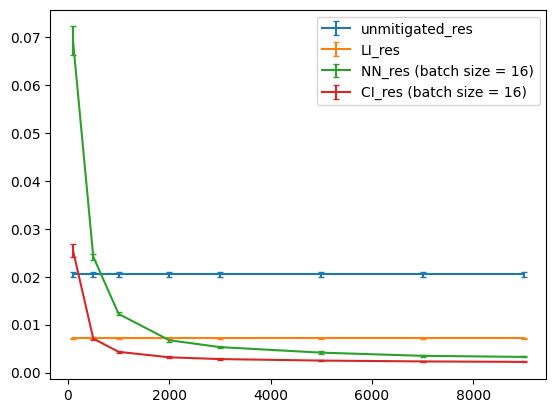

In [13]:
plt.errorbar(train_size, mean_unmiti, yerr = std_unmiti, capsize = 2, label = 'unmitigated_res')
plt.errorbar(train_size, mean_LI, yerr = std_LI, capsize = 2, label = 'LI_res')
plt.errorbar(train_size, mean_NN, yerr = std_NN, capsize = 2, label = 'NN_res (batch size = 16)')
plt.errorbar(train_size, mean_NN_CI, yerr = std_NN_CI, capsize = 2, label = 'CI_res (batch size = 16)')
plt.legend()

# transfer

In [95]:
def train_save(trainX, trainY, qubit, sz, device_type, cd):

    model = NN_model(n_qubit = qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'selu')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.0001,
        decay_steps = 100000,
        decay_rate = 0.96)
    adam = keras.optimizers.Adam(learning_rate = lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    model.fit(trainX[ : sz], trainY[ : sz], epochs = 300, batch_size = 16, verbose = 0)
    f = './' + device_type + '/' + device_type + '_' + str(qubit) + 'qubits' + cd +' model.h5'
    model.save(f)              

In [96]:
#n_qubits = [7]
#n_data = 300
#times = [39] # 11700, 39
#device_type = 'ibm_lagos' 
#number = 0

n_qubits = [7]
n_data = 300
times = [34] # 10200, 34
device_type = 'ibmq_jakarta' 
number = 0

In [97]:
X = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')
LI = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv')

In [98]:
x_cba_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(0) + '.csv') 
x_cba_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(1) + '.csv') 
x_gfe_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(2) + '.csv') 
x_gfe_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + str(3) + '.csv') 

y_cba_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(0) + '.csv') 
y_cba_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(1) + '.csv') 
y_gfe_given_d0 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(2) + '.csv') 
y_gfe_given_d1 = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + str(3) + '.csv') 

x_d = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_obs_CI_' + 'D' + '.csv') 
y_d = pd.read_csv('./' + device_type + '/' + device_type + '_' + str(n_qubits[0]) +  'qubits' + '_ideal_CI_' + 'D' + '.csv') 


In [99]:
n_train_data = 9000 # 11700, 10200 -> 9000개 고정 ->test : 2700, 1200
random_state = [56, 1, 14, 44, 71]
#train_size = [100, 500, 1000, 2000, 3000, 5000, 7000, 9000]
train_szie = [9000]

# pre- trained NN
trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = random_state[0])

trainX_cba_given_d0, testX_cba_given_d0, trainY_cba_given_d0, testY_cba_given_d0 = get_train_test_CI(x_cba_given_d0, y_cba_given_d0, n_train_data, random_state = random_state[0])
trainX_cba_given_d1, testX_cba_given_d1, trainY_cba_given_d1, testY_cba_given_d1 = get_train_test_CI(x_cba_given_d1, y_cba_given_d1, n_train_data, random_state = random_state[0])
trainX_d, testX_d, trainY_d, testY_d = get_train_test_CI(x_d, y_d, n_train_data, random_state = random_state[0])
train_save(trainX_cba_given_d0, trainY_cba_given_d0, 3, train_szie[0], device_type, cd = '_d0_')
train_save(trainX_cba_given_d1, trainY_cba_given_d1, 3, train_szie[0], device_type, cd = '_d1_')
train_save(trainX_d, trainY_d, 1, train_szie[0], device_type, cd = '_d_')


In [100]:
miti_0 = []
miti_1 = []
miti_2 = []
miti_3 = []
miti_4 = []

f_1 = './' + device_type + '/' + device_type + '_' + str(3) + 'qubits' + '_d0_' +' model.h5'
f_2 = './' + device_type + '/' + device_type + '_' + str(3) + 'qubits' + '_d1_' +' model.h5'
f_3 = './' + device_type + '/' + device_type + '_' + str(1) + 'qubits' + '_d_' +' model.h5'

model_t1 = load_model(f_1)
model_t2 = load_model(f_2)
model_t3 = load_model(f_3)

for layer in model_t1.layers:
    layer.trainable = False

for layer in model_t2.layers:
    layer.trainable = False

for layer in model_t3.layers:
    layer.trainable = False

miti_1.append(model_t1.predict(testX_cba_given_d0)) 
miti_3.append(model_t2.predict(testX_cba_given_d1))
miti_4.append(model_t3.predict(testX_d))


38/38 [==============================] - 0s 377us/step


In [101]:
model_t1.summary()

Model: "sequential_244"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1464 (Dense)          (None, 40)                360       
                                                                 
 dense_1465 (Dense)          (None, 40)                1640      
                                                                 
 dense_1466 (Dense)          (None, 40)                1640      
                                                                 
 dense_1467 (Dense)          (None, 40)                1640      
                                                                 
 dense_1468 (Dense)          (None, 40)                1640      
                                                                 
 dense_1469 (Dense)          (None, 8)                 328       
                                                                 
Total params: 7,248
Trainable params: 0
Non-trainabl

In [102]:
model_t3.summary()

Model: "sequential_246"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1476 (Dense)          (None, 10)                30        
                                                                 
 dense_1477 (Dense)          (None, 10)                110       
                                                                 
 dense_1478 (Dense)          (None, 10)                110       
                                                                 
 dense_1479 (Dense)          (None, 10)                110       
                                                                 
 dense_1480 (Dense)          (None, 10)                110       
                                                                 
 dense_1481 (Dense)          (None, 2)                 22        
                                                                 
Total params: 492
Trainable params: 0
Non-trainable 

In [103]:
model_t1.layers[5].trainable = True
model_t2.layers[5].trainable = True

In [ ]:
trainX_gfe_given_d0, testX_gfe_given_d0, trainY_gfe_given_d0, testY_gfe_given_d0 = get_train_test_CI(x_gfe_given_d0, y_gfe_given_d0, n_train_data, random_state = random_state[0])
trainX_gfe_given_d1, testX_gfe_given_d1, trainY_gfe_given_d1, testY_gfe_given_d1 = get_train_test_CI(x_gfe_given_d1, y_gfe_given_d1, n_train_data, random_state = random_state[0])

# model_t1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001,
    decay_steps = 100000,
    decay_rate = 0.96)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model_t1.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
history_1 = model_t1.fit(trainX_gfe_given_d0, trainY_gfe_given_d0, epochs = 300, batch_size = 16)

miti_0.append(model_t1.predict(testX_gfe_given_d0))        


# model_t2
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001,
    decay_steps = 100000,
    decay_rate = 0.96)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model_t2.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
history_1 = model_t2.fit(trainX_gfe_given_d1, trainY_gfe_given_d1, epochs = 300, batch_size = 16)

miti_2.append(model_t2.predict(testX_gfe_given_d1))


res_transfer = CI(miti_0, miti_1, miti_2, miti_3, miti_4)



In [105]:
miti_nn = train(trainX, trainY, testX, 7, train_szie[0])

38/38 [==============================] - 0s 3ms/step


In [106]:
unmitigated_res_t = []
LI_res_t = []
NN_res_t = []
CI_res_t =[]

unmitigated_res_t.append(loss_function(testY.values, testX.values, n_qubits[0]))
LI_res_t.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
NN_res_t.append(loss_function(testY.values, miti_nn[0], n_qubits[0]))
CI_res_t.append(loss_function(testY.values, res_transfer.values, n_qubits[0]))
        

In [107]:
def show_plot_2(topics, unmitigated, LI, NN, CI, type = 0, label = ['unmitigated', 'LI', 'NN', 'CI']):
    n = 1  # This is our first dataset (out of 2)
    t = 4 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)
    value_d_x = create_x(t, w, 4, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    x_4 = [CI[0][type]]

    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')
    ax.bar(value_d_x, x_4, label = label[3], color = 'white', edgecolor = 'black', hatch = '/////////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks([2])
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()

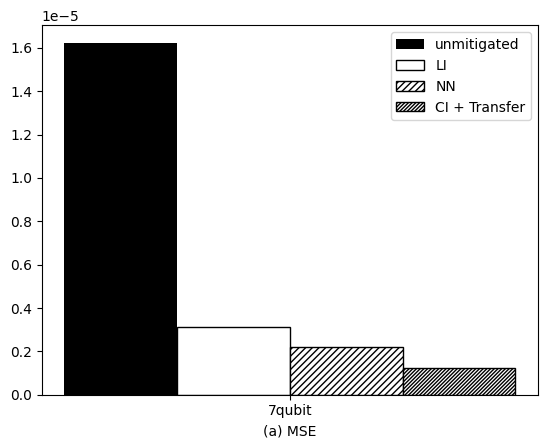

In [108]:
topics = ['7qubit']
label = ['unmitigated', 'LI', 'NN', 'CI + Transfer']
show_plot_2(topics, unmitigated_res_t, LI_res_t, NN_res_t, CI_res_t, 0, label)

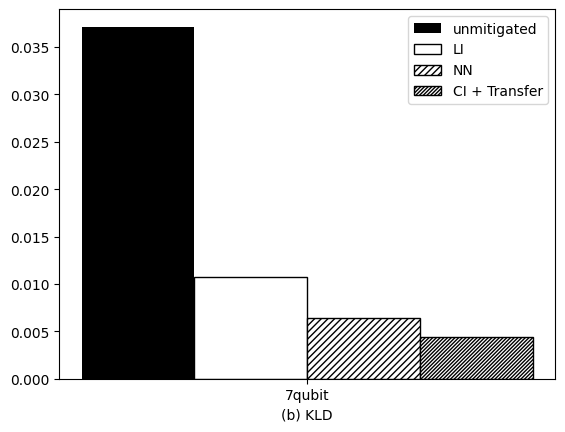

In [109]:
show_plot_2(topics, unmitigated_res_t, LI_res_t, NN_res_t, CI_res_t, 1, label)

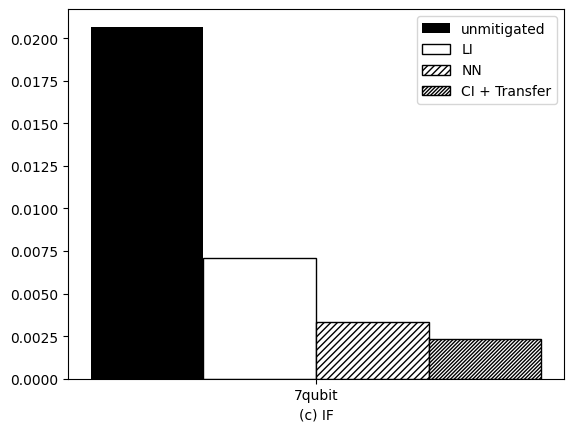

In [110]:
show_plot_2(topics, unmitigated_res_t, LI_res_t, NN_res_t, CI_res_t, 2, label)

In [111]:

print('unmitigated : ', unmitigated_res_t)
print('LI : ', LI_res_t)
print('NN : ', NN_res_t)
print('CI + transfer : ', CI_res_t)

unmitigated :  [(1.623324336415186e-05, 0.03714788568184412, 0.02067808048085885)]
LI :  [(3.118600685970454e-06, 0.01068434398795487, 0.007101566110561398)]
NN :  [(2.2238476707592262e-06, 0.006375763836953471, 0.003339230913145842)]
CI + transfer :  [(1.2175205093965958e-06, 0.0043560296873723725, 0.002326319536256549)]
